## https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import xgboost as xgb

In [3]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

`conected`を`True`にするとPlotlyのJavascriptをインターネットから取得するようになります。

In [109]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

PassengerId = test['PassengerId']#PassengerIdを保存しておく

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Feature Engineering

これを参考にするとええで：https://www.kaggle.com/sinakhorami/titanic-best-working-classifier

In [110]:
full_data = [train,test]
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


In [111]:
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

train['Has_Cabin'] = train['Cabin'].apply(lambda x:0 if type(x)==float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x:0 if type(x)==float else 1)

### 1.Pclass

In [112]:
print(train[['Pclass','Survived']].groupby(['Pclass'],as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


### 2.Sex

In [113]:
print(train[['Sex','Survived']].groupby(['Sex'],as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


### 3.SibSp and Parch

In [114]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] +1
print(train[['FamilySize','Survived']].groupby(['FamilySize'],as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


独り身のやつについても見てみようか

In [115]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1,'IsAlone'] = 1
print(train[['IsAlone','Survived']].groupby(['IsAlone'],as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


### 4.Embarked

In [116]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
print(train[['Embarked','Survived']].groupby(['Embarked'],as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


### 5.Fare

In [117]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'],4)
print(train[['CategoricalFare','Survived']].groupby(['CategoricalFare'],as_index=False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


### 6.Age

In [118]:
#欠損値の分だけランダムに値を生成して置換
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg-age_std,age_avg+age_std,age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

train['CategoricalAge'] = pd.cut(train['Age'],5)

print(train[['CategoricalAge','Survived']].groupby(['CategoricalAge'],as_index=False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.532710
1   (16.0, 32.0]  0.351770
2   (32.0, 48.0]  0.376984
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


### 7.Name

In [119]:
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.',name)
    #タイトルが存在したらそれを返す。
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
print(pd.crosstab(train['Title'],train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


タイトルをカテゴライズする

In [120]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt','Col',
                                                'Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')

print(train[['Title','Survived']].groupby(['Title'],as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


In [121]:
for dataset in full_data:
    #mapping sex
    dataset['Sex'] = dataset['Sex'].map({'female':0,'male':1}).astype(int)
    
    #mapping title
    title_mapping = {'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Rare':5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    #mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [122]:
#特徴量選択
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [123]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int32
Age            891 non-null int32
Parch          891 non-null int64
Fare           891 non-null int32
Embarked       891 non-null int32
Name_length    891 non-null int64
Has_Cabin      891 non-null int64
FamilySize     891 non-null int64
IsAlone        891 non-null int64
Title          891 non-null int64
dtypes: int32(4), int64(8)
memory usage: 69.7 KB


In [124]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
Pclass         418 non-null int64
Sex            418 non-null int32
Age            418 non-null int32
Parch          418 non-null int64
Fare           418 non-null int32
Embarked       418 non-null int32
Name_length    418 non-null int64
Has_Cabin      418 non-null int64
FamilySize     418 non-null int64
IsAlone        418 non-null int64
Title          418 non-null int64
dtypes: int32(4), int64(7)
memory usage: 29.5 KB


In [125]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


In [126]:
test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1
3,3,1,1,0,1,0,16,0,1,1,1
4,3,0,1,1,1,0,44,0,3,0,3


##### 相関

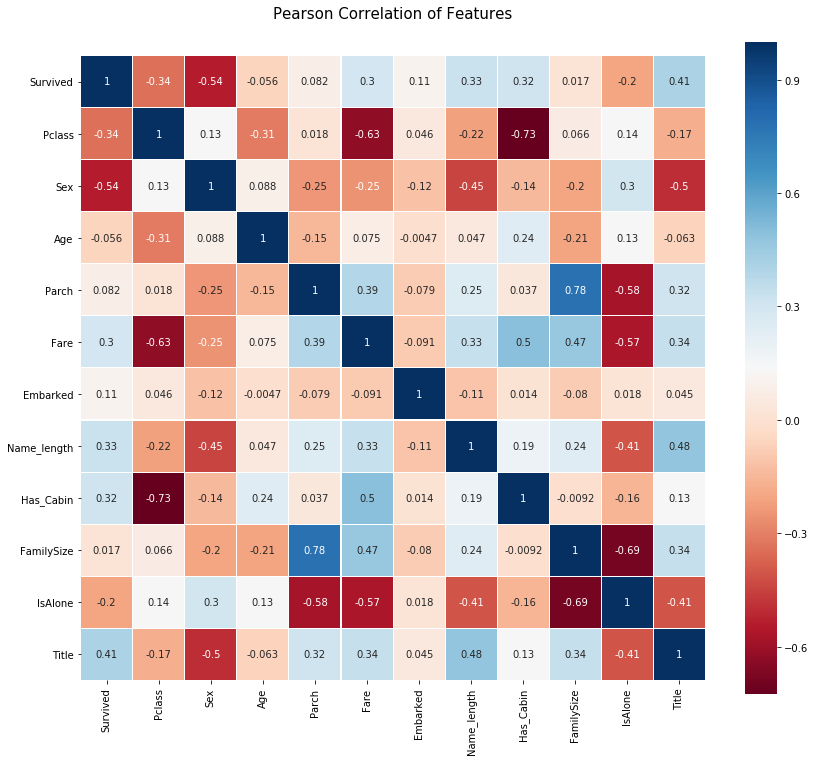

In [127]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features',y=1.05,size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
            linecolor='white',annot=True)

`annot=True`は数値を表示する

Pearson Correlationプロットが教えてくれることの1つは、あまりにも多くの特徴が互いに強く相関していないということです。 これは、学習モデルにこれらのフィーチャを追加するという観点からは優れています。これは、トレーニングセットに余計なデータや余計なデータがないことを意味し、各フィーチャに固有の情報があることを嬉しく思います。 ここでは、家族の大きさとParch（親と子）の2つの最も関連性の高い機能があります。 この演習の目的では、両方の機能を残しておきます。

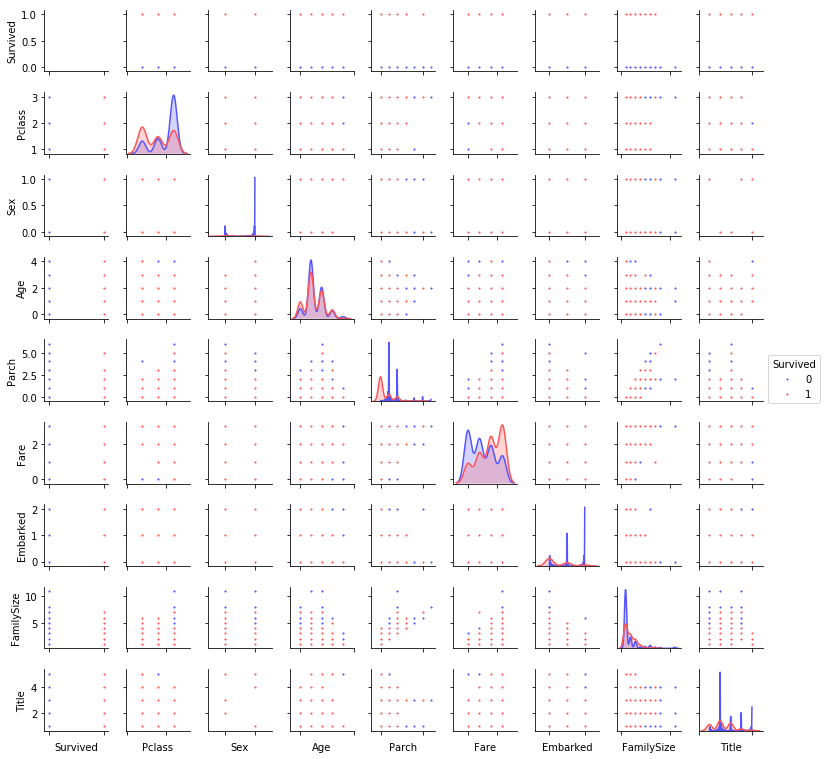

In [128]:
g = sns.pairplot(train[['Survived','Pclass','Sex','Age','Parch','Fare','Embarked',
                        'FamilySize','Title']], hue='Survived', palette = 'seismic',
                 size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

- カテゴリデータに従って色分け: `hue`
- カテゴリの順番を指定: `hue_order`
- カテゴリの色を指定: `palette`
- グラフ化する列を指定: `vars, x_vars, y_vars`
- マーカーを指定: `markers`
- 回帰直線を重ねてプロット: `kind=reg`
- 対角線のグラフの種類をカーネル密度分布に変更: `diag_kind`
- サイズを指定: `size`

### Ensembling & Stacking models
以下ではすべての分類器に共通の組み込みメソッド（train,predict,fit)を拡張できる`SklearnHelper`クラスを作成する。

#### [スタッキングについて](http://st-hakky.hatenablog.com/entry/2017/07/28/214518)

1. トレーニングデータを複数のfoldに分割する
2. そのうちの1つを取り除き、残りのセットを使ってステージ0の学習機を学習させる
3. そして学習に使用していないデータに対して、学習機に予測させることで、ブレンドデータを得る。
4. 正解データとステージ0から得たすべてのブレンドデータを使って、ステージ1の学習機を学習する。

In [129]:
#いくつかの使えるパラメータ
ntrain = train.shape[0]
ntest = test.shape[0]
Seed = 0
NFOLDS = 5
kf = KFold(ntrain,n_folds=NFOLDS,random_state=Seed)

class SklearnHelper(object):
    def __init__(self,clf,seed=0,params=None):
        params['random_state'] = 0
        self.clf = clf(**params)
    
    def train(self,x_train,y_train):
        self.clf.fit(x_train,y_train)
    
    def predict(self,x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
        

### out-of-fold predictions
第2レベルへのトレーニングの入力として基本分類器の予測が使用される

In [130]:
#第2レベルに渡すトレーニングデータが作られる。
def get_oof(clf,x_train,y_train,x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS,ntest))
    
    for i,(train_index,test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        #分類器学習
        clf.train(x_tr,y_tr)
        #予測してデータの作成
        oof_train[test_index] = clf.predict(x_te)
        #教師データ
        oof_test_skf[i,:] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1),oof_test.reshape(-1,1)

### 1次モデルの作成
それでは、最初のレベルの分類として5つの学習モデルを用意しましょう。これらのモデルはすべてSklearnライブラリを介して呼び出すことができ、以下のようにリストされます：

1. Random Forest classifier
2. Extra Trees classifier
3. AdaBoost classifer
4. Gradient Boosting classifer
5. Support Vector Machine

[アンサンブル学習のブースティングとバギングについて](https://analytics-and-intelligence.net/archives/678)


完全性のためにここにリストアップするパラメータの簡単な要約だけで、

n_jobs：トレーニングプロセスに使用されたコアの数。 -1に設定すると、すべてのコアが使用されます。

n_estimators：学習モデルの分類ツリーの数（デフォルトで10に設定）

max_depth：ツリーの最大深度、またはノードをどれだけ拡張するか。あまりにも高い数に設定されていると、あまりにも深刻なツリーを成長させるので、オーバーフィットのリスクを冒すことに注意してください

verbose：学習プロセス中にテキストを出力するかどうかを制御します。 0の値はすべてのテキストを抑制し、3の値は各繰り返しでツリー学習プロセスを出力します。


In [131]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [132]:
#分類器オブジェクト作成
rf = SklearnHelper(clf=RandomForestClassifier,seed=Seed,params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=Seed, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=Seed, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=Seed, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=Seed, params=svc_params)

In [133]:
#データをnumpy形式にする
y_train = train['Survived'].ravel()
train = train.drop(['Survived'],axis=1)
x_train = train.values
x_test = test.values

### outupt of the first level prediction
トレーニングとテストデータを5つの基本分類器に送り、前に定義した関数を使用して、最初のレベルの予測を生成する。

In [134]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


### Feature importances generated from the different classifiers
今、最初のレベルの分類器を学んだので、Sklearnモデルの非常に素晴らしい機能を利用できます。それは、非常に簡単なコード行でトレーニングとテストセットのさまざまな機能の重要度を出力することです。

Sklearnのドキュメントによると、ほとんどの分類器は、単にフィーチャインポートを入力するだけでフィーチャのインポートを返す属性で組み込まれています。 したがって、関数earliを使用してこの非常に有用な属性を呼び出し、そのような特徴の重要度をプロットします

In [135]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.12463748 0.19718227 0.03140236 0.02019233 0.07345467 0.02378238
 0.10698858 0.06501071 0.06724059 0.01374771 0.27636093]
[0.12104685 0.3846739  0.02699777 0.01625976 0.05693523 0.02938927
 0.0478511  0.08256349 0.04454583 0.02230187 0.16743492]
[0.026 0.012 0.018 0.062 0.038 0.01  0.702 0.012 0.052 0.002 0.066]
[0.0718004  0.02843047 0.08504723 0.04073875 0.10985185 0.06133329
 0.41331027 0.01556621 0.06503494 0.02406766 0.08481892]


In [136]:
rf_feature = [0.12463748, 0.19718227, 0.03140236, 0.02019233, 0.07345467, 0.02378238,
 0.10698858, 0.06501071, 0.06724059, 0.01374771, 0.27636093]
et_feature = [0.12104685, 0.3846739,  0.02699777, 0.01625976, 0.05693523, 0.02938927,
 0.0478511,  0.08256349, 0.04454583, 0.02230187, 0.16743492]
ada_feature = [0.026, 0.012, 0.018, 0.062, 0.038, 0.01,  0.702, 0.012, 0.052, 0.002, 0.066]
gb_feature = [0.0718004,  0.02843047, 0.08504723, 0.04073875, 0.10985185, 0.06133329,
 0.41331027, 0.01556621, 0.06503494, 0.02406766, 0.08481892]

In [137]:
cols = test.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
    })

In [138]:
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,0.124637,0.121047,0.026,0.071800
1,Sex,0.197182,0.384674,0.012,0.028430
2,Age,0.031402,0.026998,0.018,0.085047
3,Parch,0.020192,0.016260,0.062,0.040739
4,Fare,0.073455,0.056935,0.038,0.109852
5,Embarked,0.023782,0.029389,0.010,0.061333
6,Name_length,0.106989,0.047851,0.702,0.413310
7,Has_Cabin,0.065011,0.082563,0.012,0.015566
8,FamilySize,0.067241,0.044546,0.052,0.065035
9,IsAlone,0.013748,0.022302,0.002,0.024068


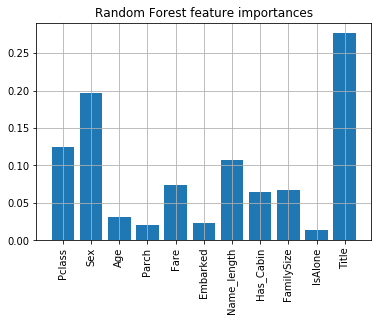

In [139]:
label = feature_dataframe['features']
plt.bar([i for i in range(len(feature_dataframe.index))],
        feature_dataframe['Random Forest feature importances'],tick_label=label)
plt.xticks(rotation=90)
plt.title('Random Forest feature importances')
plt.grid()


In [140]:
def important_graph(classifiers):
    label = feature_dataframe['features']
    plt.bar([i for i in range(len(feature_dataframe.index))],
        feature_dataframe[classifiers],tick_label=label)
    plt.xticks(rotation=90)
    plt.title(classifiers)
    plt.grid()
    plt.show()

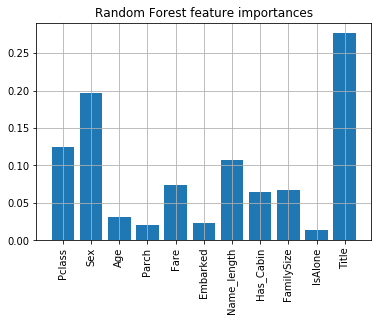

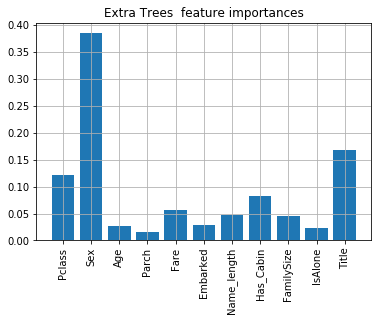

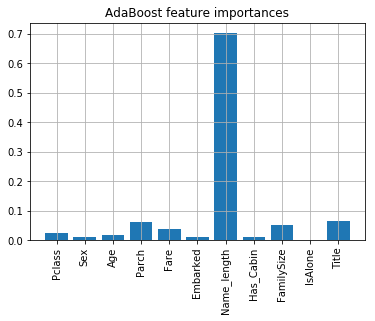

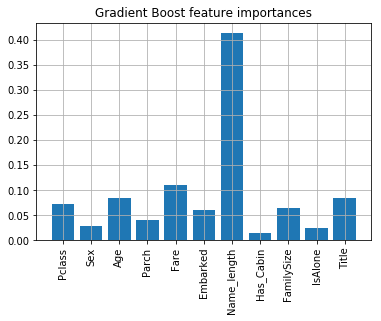

In [141]:
for classifier in feature_dataframe.columns[1:]:
    important_graph(classifier)


In [142]:
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.124637,0.121047,0.026,0.071800,0.085871
1,Sex,0.197182,0.384674,0.012,0.028430,0.155572
2,Age,0.031402,0.026998,0.018,0.085047,0.040362
3,Parch,0.020192,0.016260,0.062,0.040739,0.034798
4,Fare,0.073455,0.056935,0.038,0.109852,0.069560
5,Embarked,0.023782,0.029389,0.010,0.061333,0.031126
6,Name_length,0.106989,0.047851,0.702,0.413310,0.317537
7,Has_Cabin,0.065011,0.082563,0.012,0.015566,0.043785
8,FamilySize,0.067241,0.044546,0.052,0.065035,0.057205
9,IsAlone,0.013748,0.022302,0.002,0.024068,0.015529


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

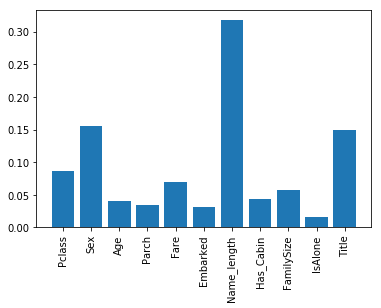

In [143]:
plt.bar([i for i in range(len(feature_dataframe.index))],
        feature_dataframe['mean'],tick_label=label)
plt.xticks(rotation=90)

#### First-level output as new features

Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [147]:
#第2モデルに入れる訓練データの作成
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


### XGBoostによる第2モデルの学習


In [145]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [146]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)